In [1]:
from __future__ import division
from sys import exit
from math import sqrt
from numpy import array
from scipy.optimize import fmin_l_bfgs_b

def RMSE(params, *args):

    Y = args[0]
    type = args[1]
    rmse = 0

    if type == 'linear':

        alpha, beta = params
        a = [Y[0]]
        b = [Y[1] - Y[0]]
        y = [a[0] + b[0]]

        for i in range(len(Y)):

            a.append(alpha * Y[i] + (1 - alpha) * (a[i] + b[i]))
            b.append(beta * (a[i + 1] - a[i]) + (1 - beta) * b[i])
            y.append(a[i + 1] + b[i + 1])

    else:

        alpha, beta, gamma = params
        m = args[2]     
        a = [sum(Y[0:m]) / float(m)]
        b = [(sum(Y[m:2 * m]) - sum(Y[0:m])) / m ** 2]

        if type == 'additive':

            s = [Y[i] - a[0] for i in range(m)]
            y = [a[0] + b[0] + s[0]]

            for i in range(len(Y)):

                a.append(alpha * (Y[i] - s[i]) + (1 - alpha) * (a[i] + b[i]))
                b.append(beta * (a[i + 1] - a[i]) + (1 - beta) * b[i])
                s.append(gamma * (Y[i] - a[i] - b[i]) + (1 - gamma) * s[i])
                y.append(a[i + 1] + b[i + 1] + s[i + 1])

        elif type == 'multiplicative':

            s = [Y[i] / a[0] for i in range(m)]
            y = [(a[0] + b[0]) * s[0]]

            for i in range(len(Y)):

                a.append(alpha * (Y[i] / s[i]) + (1 - alpha) * (a[i] + b[i]))
                b.append(beta * (a[i + 1] - a[i]) + (1 - beta) * b[i])
                s.append(gamma * (Y[i] / (a[i] + b[i])) + (1 - gamma) * s[i])
                y.append((a[i + 1] + b[i + 1]) * s[i + 1])

        else:

            exit('Type must be either linear, additive or multiplicative')

    rmse = sqrt(sum([(m - n) ** 2 for m, n in zip(Y, y[:-1])]) / len(Y))

    return rmse

def linear(x, fc, alpha = None, beta = None):

    Y = x[:]

    if (alpha == None or beta == None):

        initial_values = array([0.3, 0.1])
        boundaries = [(0, 1), (0, 1)]
        type = 'linear'

        
        parameters = fmin_l_bfgs_b(RMSE, x0 = initial_values, args = (Y, type), bounds = boundaries, approx_grad = True)
        alpha, beta = parameters[0]

    a = [Y[0]]
    b = [Y[1] - Y[0]]
    y = [a[0] + b[0]]
    rmse = 0

    for i in range(len(Y) + fc):

        if i == len(Y):
            Y.append(a[-1] + b[-1])

        a.append(alpha * Y[i] + (1 - alpha) * (a[i] + b[i]))
        b.append(beta * (a[i + 1] - a[i]) + (1 - beta) * b[i])
        y.append(a[i + 1] + b[i + 1])

    rmse = sqrt(sum([(m - n) ** 2 for m, n in zip(Y[:-fc], y[:-fc - 1])]) / len(Y[:-fc]))

    return Y[-fc:], alpha, beta, rmse

def additive(x, m, fc, alpha = None, beta = None, gamma = None):

    Y = x[:]

    if (alpha == None or beta == None or gamma == None):

        initial_values = array([0.3, 0.1, 0.1])
        boundaries = [(0, 1), (0, 1), (0, 1)]
        type = 'additive'

        parameters = fmin_l_bfgs_b(RMSE, x0 = initial_values, args = (Y, type, m), bounds = boundaries, approx_grad = True)
        alpha, beta, gamma = parameters[0]

    a = [sum(Y[0:m]) / float(m)]
    b = [(sum(Y[m:2 * m]) - sum(Y[0:m])) / m ** 2]
    s = [Y[i] - a[0] for i in range(m)]
    y = [a[0] + b[0] + s[0]]
    rmse = 0

    for i in range(len(Y) + fc):

        if i == len(Y):
            Y.append(a[-1] + b[-1] + s[-m])

        a.append(alpha * (Y[i] - s[i]) + (1 - alpha) * (a[i] + b[i]))
        b.append(beta * (a[i + 1] - a[i]) + (1 - beta) * b[i])
        s.append(gamma * (Y[i] - a[i] - b[i]) + (1 - gamma) * s[i])
        y.append(a[i + 1] + b[i + 1] + s[i + 1])

    rmse = sqrt(sum([(m - n) ** 2 for m, n in zip(Y[:-fc], y[:-fc - 1])]) / len(Y[:-fc]))

    return Y[-fc:], alpha, beta, gamma, rmse


def multiplicative(x, m, fc, alpha = None, beta = None, gamma = None):

    Y = x[:]  # Y是输入，也就是x。

    if (alpha == None or beta == None or gamma == None):

        initial_values = array([0.0, 1.0, 0.0])
        boundaries = [(0, 1), (0, 1), (0, 1)]
        type = 'multiplicative'
        # RMSE最小准则来寻找parameters
        parameters = fmin_l_bfgs_b(RMSE, x0 = initial_values, args = (Y, type, m), bounds = boundaries, approx_grad = True)
        alpha, beta, gamma = parameters[0]

    a = [sum(Y[0:m]) / float(m)]                     #s
    b = [(sum(Y[m:2 * m]) - sum(Y[0:m])) / m ** 2]   # t
    s = [Y[i] / a[0] for i in range(m)]              # p
    y = [(a[0] + b[0]) * s[0]]
    rmse = 0

    for i in range(len(Y) + fc):

        if i == len(Y):
            Y.append((a[-1] + b[-1]) * s[-m])  # 加入预测值

        a.append(alpha * (Y[i] / s[i]) + (1 - alpha) * (a[i] + b[i]))
        b.append(beta * (a[i + 1] - a[i]) + (1 - beta) * b[i])
        s.append(gamma * (Y[i] / (a[i] + b[i])) + (1 - gamma) * s[i])
        y.append((a[i + 1] + b[i + 1]) * s[i + 1])

    rmse = sqrt(sum([(m - n) ** 2 for m, n in zip(Y[:-fc], y[:-fc - 1])]) / len(Y[:-fc]))

    return Y[-fc:], alpha, beta, gamma, rmse

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

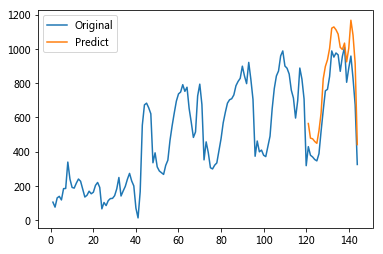

In [6]:
peo = pd.read_csv("top2peo")
data=np.array(peo.peo).tolist()
y1,alpha,beta,gamma,rsme =multiplicative(data,24,24)
y=np.array(peo.peo).tolist()
x=range(1,145)
x1=range(121,145)
plt.plot(x,y,label='Original')
plt.plot(x1,y1,label='Predict')
plt.legend(loc='best')
plt.show()

In [7]:
rm = sqrt(sum([(m-n)**2 for m,n in zip(y1[:],y[120:145])]))/len(y1)
rm

29.81706891638973

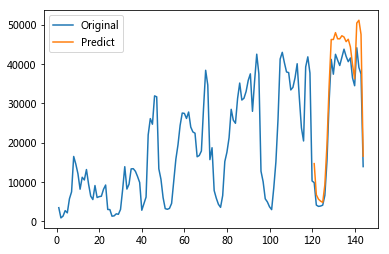

1090.6714386652027

In [8]:
peo = pd.read_csv("top2hour")
data=np.array(peo.connect).tolist()
y1,alpha,beta,gamma,rsme =multiplicative(data,24,24)
y=np.array(peo.connect).tolist()
x=range(1,145)
x1=range(121,145)
plt.plot(x,y,label='Original')
plt.plot(x1,y1,label='Predict')
plt.legend(loc='best')
plt.show()
rm = sqrt(sum([(m-n)**2 for m,n in zip(y1[:],y[120:145])]))/len(y1)
rm

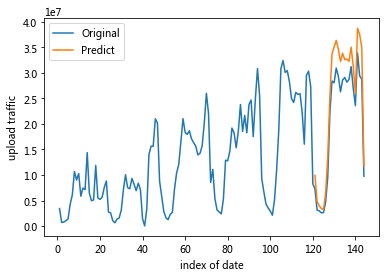

886091.5548917936

In [9]:
peo = pd.read_csv("top2upload")
data=np.array(peo.upload).tolist()
y1,alpha,beta,gamma,rsme =multiplicative(data,24,24)
y=np.array(peo.upload).tolist()
x=range(1,145)
x1=range(121,145)
plt.plot(x,y,label='Original')
plt.plot(x1,y1,label='Predict')
plt.xlabel("index of date")
plt.ylabel("upload traffic")
plt.legend(loc='best')
plt.show()
rm = sqrt(sum([(m-n)**2 for m,n in zip(y1[:],y[120:145])]))/len(y1)
rm

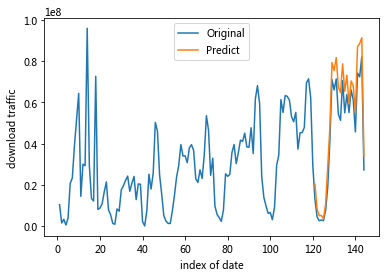

1784537.6157236628

In [10]:
peo = pd.read_csv("top2download")
data=np.array(peo.download).tolist()
y1,alpha,beta,gamma,rsme =multiplicative(data,24,24)
y=np.array(peo.download).tolist()
x=range(1,145)
x1=range(121,145)
plt.plot(x,y,label='Original')
plt.plot(x1,y1,label='Predict')
plt.xlabel("index of date")
plt.ylabel("download traffic")
plt.legend(loc='best')
plt.show()
rm = sqrt(sum([(m-n)**2 for m,n in zip(y1[:],y[120:145])]))/len(y1)
rm

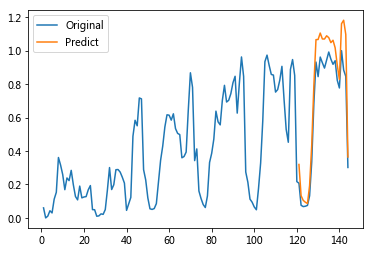

0.027585380148900693

In [11]:
peo = pd.read_csv("top2hour")
tmp = np.array(peo.connect).tolist()
data = list((float)(i-np.min(tmp))/(np.max(tmp)-np.min(tmp)) for i in tmp)
len(data)
y1,alpha,beta,gamma,rsme =multiplicative(data[2:145],24,24)
y=np.array(data).tolist()
x=range(1,145)
x1=range(121,145)
plt.plot(x,y,label='Original')
plt.plot(x1,y1,label='Predict')
plt.legend(loc='best')
plt.show()
rm = sqrt(sum([(m-n)**2 for m,n in zip(y1[:],y[120:145])]))/len(y1)
rm